In [1]:
pip install pycocoevalcap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from PIL import Image
import matplotlib.pylab as plt
from textwrap import wrap
from tensorflow.keras.layers import (
    StringLookup
)
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm
from tabulate import tabulate
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from nltk.translate.meteor_score import meteor_score

In [3]:
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )

In [4]:
# 2. Load the tokenizer model
loaded_model = tf.keras.models.load_model('/Users/yapyu/Desktop/DS Project/model/Additive Attention Flickr/2_Image Caption Additive Attention Flickr 30K version (662) v8/tokenizer_model', custom_objects={'standardize': standardize})
tokenizer = loaded_model.layers[1]

# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

In [5]:
encoder = tf.keras.models.load_model('/Users/yapyu/Desktop/DS Project/model/Additive Attention Flickr/2_Image Caption Additive Attention Flickr 30K version (662) v8/encoder')

decoder_pred_model = tf.keras.models.load_model('/Users/yapyu/Desktop/DS Project/model/Additive Attention Flickr/2_Image Caption Additive Attention Flickr 30K version (662) v8/decoder_pred_model')

In [6]:
# Load the dataset
file_path = '/Users/yapyu/Desktop/DS Project/Flickr8K/captions.txt'
data = pd.read_csv(file_path, sep=',', engine='python')
data.columns = [col.strip() for col in data.columns]
data['caption'] = data['caption'].astype(str)

In [7]:
BUFFER_SIZE = 1500
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
ATTENTION_DIM = 512
MAX_CAPTION_LEN = 64
# Define the base path where images are stored
base_image_path = '/Users/yapyu/Desktop/DS Project/Flickr8K/Images/'

# Assuming 'data' is a DataFrame containing your training data with columns 'image_name' and 'comment'
# Extract image paths and captions
image_paths = [os.path.join(base_image_path, fname) for fname in data['image']]
captions = data['caption'].tolist()

# Define image processing function
def load_and_process_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255.0
    return img

def get_image_label_pair(image_path, caption):
    img = load_and_process_image(image_path)
    return {"image_tensor": img, "caption": caption}

# Create a dataset from the image paths and captions
testds = tf.data.Dataset.from_tensor_slices((image_paths, captions))

# Map the function over the dataset
testds = testds.map(
    get_image_label_pair, num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle and prefetch the dataset
testds = testds.shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

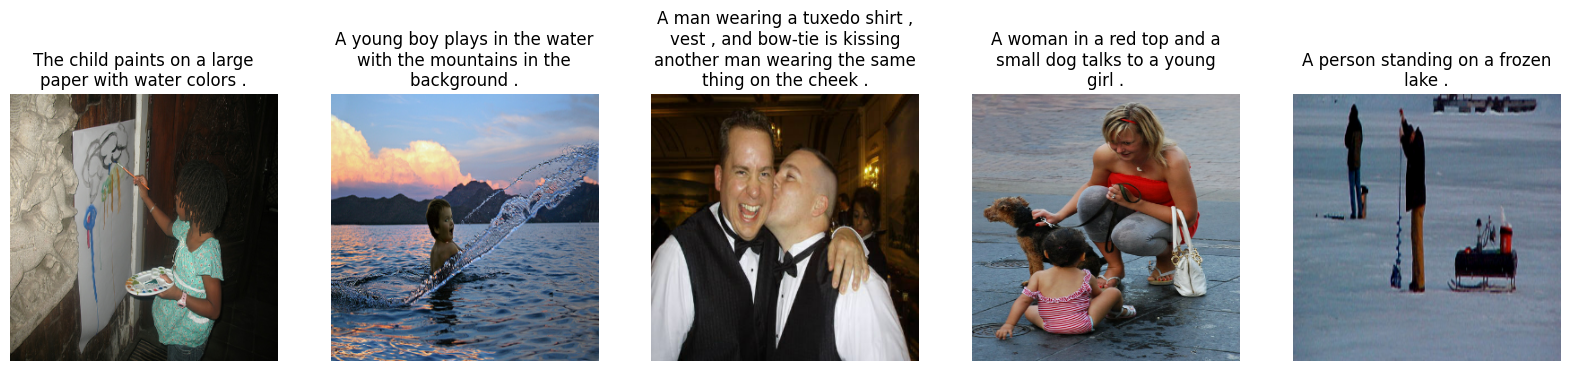

In [8]:
f, ax = plt.subplots(1, 5, figsize=(20, 5))
for idx, data in enumerate(testds.take(5)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

## Stochastic Sampling

In [9]:
## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

#   If you are using InceptionResnetV2 below is the preprocessing steps for it.
#     img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
#     img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = img / 255
    
    features = encoder(tf.expand_dims(filename, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return filename, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return filename, result

## Beam Search

In [10]:
def predict_caption_beam_search(filename, beam_width=3):
    # Preprocess the image
#     img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
#     img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
#     img = img / 255.0

    # Extract features using the encoder
    features = encoder(tf.expand_dims(filename, axis=0))

    # Start with the <start> token for each beam
    start_token = word_to_index("<start>")
    dec_input = tf.expand_dims([start_token], 0)
    gru_state = tf.zeros((1, ATTENTION_DIM))

    # Initial states of the beams
    beams = [(dec_input, gru_state, 0, [])]  # Each beam is a tuple (decoder_input, gru_state, score, caption_sequence)

    for i in range(MAX_CAPTION_LEN):
        new_beams = []
        for dec_input, gru_state, score, caption_sequence in beams:
            # Get predictions and update GRU state
            predictions, gru_state = decoder_pred_model([dec_input, gru_state, features])

            # Apply softmax to convert logits to probabilities
            predictions = tf.nn.softmax(predictions, axis=-1)

            # Get top k probabilities and their indices
            top_probs, top_idxs = tf.math.top_k(predictions, k=beam_width)

            # For each beam, add the top k possibilities
            for j in range(beam_width):
                next_word_idx = top_idxs[0][0][j].numpy()
                next_word = tokenizer.get_vocabulary()[next_word_idx]
                next_score = score + tf.math.log(top_probs[0][0][j])

                # If the next word is <end>, we complete the caption
                if next_word == "<end>":
                    return filename, caption_sequence + [next_word]

                # Otherwise, we add the next word to the beam
                new_beam = (tf.expand_dims([next_word_idx], 0), gru_state, next_score, caption_sequence + [next_word])
                new_beams.append(new_beam)

        # Sort all possible beams by their score and select the top k to continue
        beams = sorted(new_beams, key=lambda beam: beam[2], reverse=True)[:beam_width]

    # If the loop ends because MAX_CAPTION_LEN is reached, return the highest scoring beam
    return filename, max(beams, key=lambda beam: beam[2])[3]

## Greedy Search

In [11]:
def predict_caption_greedy(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))
    
    features = encoder(tf.expand_dims(filename, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []

    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # Use argmax to select the word with the highest probability
        predicted_id = tf.argmax(predictions, axis=-1)[0][0].numpy()

        # Append the predicted word to the result
        predicted_word = tokenizer.get_vocabulary()[predicted_id]
        result.append(predicted_word)

        # Stop if the <end> token is predicted
        if predicted_word == "<end>":
            return filename, result

        # Prepare the input for the next word prediction
        dec_input = tf.expand_dims([predicted_id], 0)

    return filename, result

In [12]:
def clean_reference(inputs):
    # Lowercase the input string
    inputs = inputs.lower()
    # Remove punctuation using regex
    return re.sub(r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", "", inputs)

In [13]:
def evaluate_combined(dataset, num_examples, predict_function):
    actual_dict = {}
    predicted_dict = {}
    meteor_scores = []

    for idx, example in enumerate(tqdm(dataset.take(num_examples), total=num_examples, desc="Evaluating Combined Metrics")):
        # Generate predicted caption
        image_tensor = example['image_tensor']
        _, predicted_caption = predict_function(image_tensor)
        predicted_caption_raw = ' '.join(predicted_caption[:-1])  # Remove <end> token

        # Assume image_tensor can be used as an image ID
        img_id = str(idx)

        # Clean and tokenize reference caption for METEOR
        reference_caption_raw = clean_reference(example['caption'].numpy().decode('utf-8'))
        reference_caption_tokenized = word_tokenize(reference_caption_raw)
        predicted_caption_tokenized = word_tokenize(predicted_caption_raw)

        # Calculate METEOR score for this example and append
        meteor_score_val = meteor_score([reference_caption_tokenized], predicted_caption_tokenized)
        meteor_scores.append(meteor_score_val)

        # Store the raw captions for pycocoevalcap evaluation
        actual_dict[img_id] = [reference_caption_raw]
        predicted_dict[img_id] = [predicted_caption_raw]

    # Compute pycocoevalcap scores
    pycoco_scores = {}
    scorers = [
        (Bleu(4), ["BLEU_1", "BLEU_2", "BLEU_3", "BLEU_4"]),
        (Rouge(), "ROUGE-L"),
        (Cider(), "CIDEr")
    ]
    for scorer, method in scorers:
        score, _ = scorer.compute_score(actual_dict, predicted_dict)
        if isinstance(method, list):
            for m, s in zip(method, score):
                pycoco_scores[m] = s
        else:
            pycoco_scores[method] = score

    # Average METEOR score
    avg_meteor_score = sum(meteor_scores) / len(meteor_scores)

    return pycoco_scores, avg_meteor_score

## Evaluations

Evaluating Combined Metrics: 100%|█████████████████████████████████████████████████| 2000/2000 [45:01<00:00,  1.35s/it]


Evaluation Scores for Beam Search n=1: 

PyCOCOevalcap Scores: 

BLEU_1: 0.6118
BLEU_2: 0.4320
BLEU_3: 0.2937
BLEU_4: 0.2284
ROUGE-L: 0.2996
CIDEr: 0.5884

METEOR Score: 0.2666


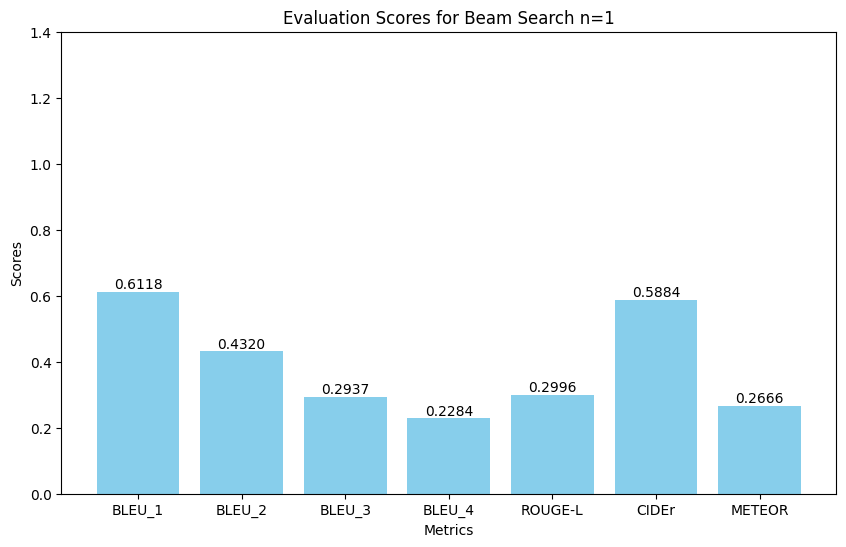

In [14]:
# Redirect standard output
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
predict_beam_search1 = lambda image_tensor: predict_caption_beam_search(image_tensor, beam_width=1)
pycoco_scores, avg_meteor_score = evaluate_combined(testds, 2000, predict_beam_search1)
# Reset standard output
sys.stdout = original_stdout
print("Evaluation Scores for Beam Search n=1: \n") 
# Print the results
print("PyCOCOevalcap Scores: \n")
for key, value in pycoco_scores.items():
    print(f"{key}: {value:.4f}")
print(f"\nMETEOR Score: {avg_meteor_score:.4f}")

# Prepare data for plotting
metrics = list(pycoco_scores.keys())
scores = list(pycoco_scores.values())

# Add METEOR to the metrics and its average score
metrics.append("METEOR")
scores.append(avg_meteor_score)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Scores for Beam Search n=1')
plt.ylim(0, 1.4)  # Assuming scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i], f'{scores[i]:.4f}', ha='center', va='bottom')

# Display the plot
plt.show()

Evaluating Combined Metrics: 100%|███████████████████████████████████████████████| 2000/2000 [1:13:48<00:00,  2.21s/it]


Evaluation Scores for Beam Search n=2: 

PyCOCOevalcap Scores: 

BLEU_1: 0.6036
BLEU_2: 0.4273
BLEU_3: 0.2923
BLEU_4: 0.2277
ROUGE-L: 0.2989
CIDEr: 0.5886

METEOR Score: 0.2596


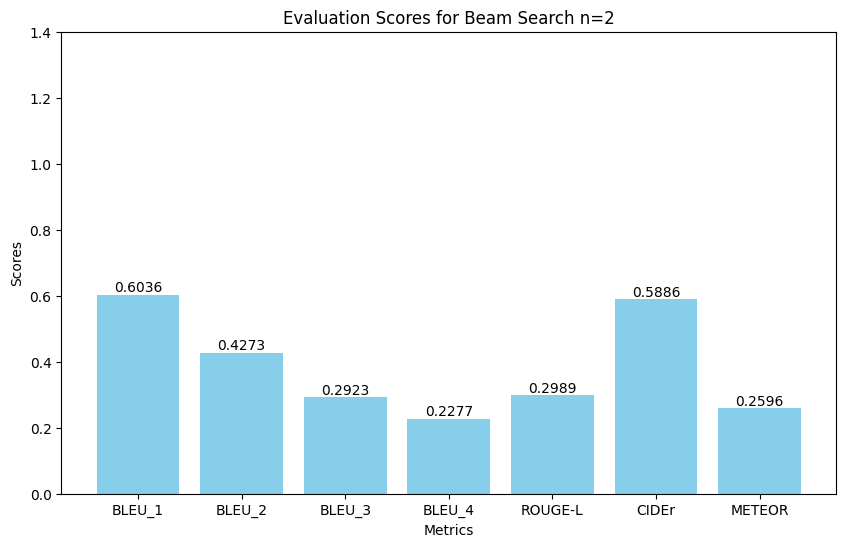

In [15]:
# Example usage
# Redirect standard output
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
predict_beam_search2 = lambda image_tensor: predict_caption_beam_search(image_tensor, beam_width=2)
pycoco_scores, avg_meteor_score = evaluate_combined(testds, 2000, predict_beam_search2)
sys.stdout = original_stdout
print("Evaluation Scores for Beam Search n=2: \n") 
# Print the results
print("PyCOCOevalcap Scores: \n")
for key, value in pycoco_scores.items():
    print(f"{key}: {value:.4f}")
print(f"\nMETEOR Score: {avg_meteor_score:.4f}")

# Prepare data for plotting
metrics = list(pycoco_scores.keys())
scores = list(pycoco_scores.values())

# Add METEOR to the metrics and its average score
metrics.append("METEOR")
scores.append(avg_meteor_score)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Scores for Beam Search n=2')
plt.ylim(0, 1.4)  # Assuming scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i], f'{scores[i]:.4f}', ha='center', va='bottom')

# Display the plot
plt.show()

Evaluating Combined Metrics: 100%|███████████████████████████████████████████████| 2000/2000 [1:51:23<00:00,  3.34s/it]


Evaluation Scores for Beam Search n=3: 

PyCOCOevalcap Scores: 

BLEU_1: 0.5910
BLEU_2: 0.4203
BLEU_3: 0.2894
BLEU_4: 0.2282
ROUGE-L: 0.3006
CIDEr: 0.5898

METEOR Score: 0.2554


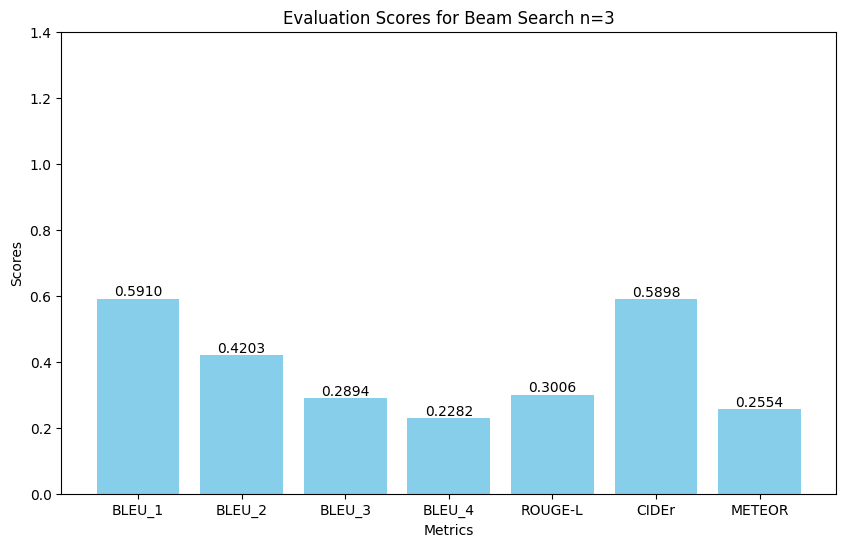

In [16]:
# Redirect standard output
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
predict_beam_search3 = lambda image_tensor: predict_caption_beam_search(image_tensor, beam_width=3)
pycoco_scores, avg_meteor_score = evaluate_combined(testds, 2000, predict_beam_search3)
sys.stdout = original_stdout
print("Evaluation Scores for Beam Search n=3: \n") 
# Print the results
print("PyCOCOevalcap Scores: \n")
for key, value in pycoco_scores.items():
    print(f"{key}: {value:.4f}")
print(f"\nMETEOR Score: {avg_meteor_score:.4f}")

# Prepare data for plotting
metrics = list(pycoco_scores.keys())
scores = list(pycoco_scores.values())

# Add METEOR to the metrics and its average score
metrics.append("METEOR")
scores.append(avg_meteor_score)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Scores for Beam Search n=3')
plt.ylim(0, 1.4)  # Assuming scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i], f'{scores[i]:.4f}', ha='center', va='bottom')

# Display the plot
plt.show()

Evaluating Combined Metrics: 100%|█████████████████████████████████████████████████| 2000/2000 [47:57<00:00,  1.44s/it]


Evaluation Scores for Stochastic Sampling: 

PyCOCOevalcap Scores: 

BLEU_1: 0.5302
BLEU_2: 0.3577
BLEU_3: 0.2364
BLEU_4: 0.1883
ROUGE-L: 0.2306
CIDEr: 0.2996

METEOR Score: 0.2054


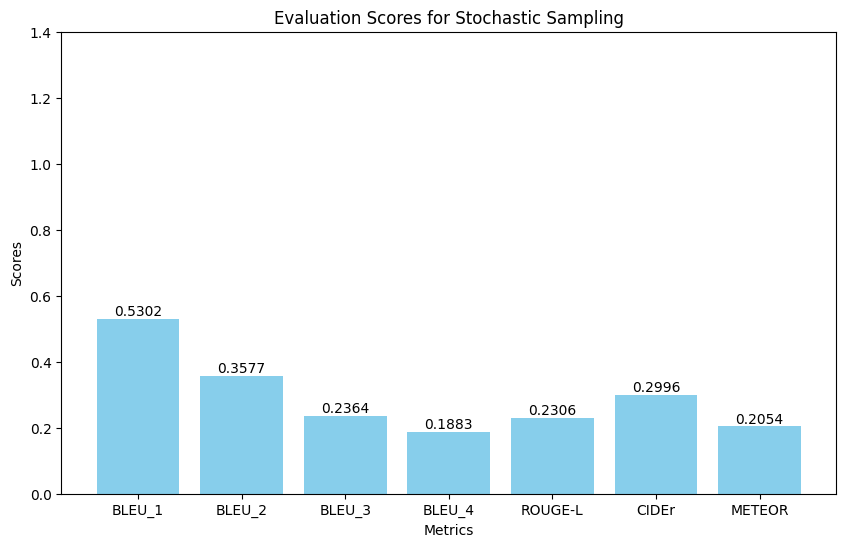

In [17]:
# Redirect standard output
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
predict_stochastic = lambda image_tensor: predict_caption(image_tensor)
pycoco_scores, avg_meteor_score = evaluate_combined(testds, 2000, predict_stochastic)
sys.stdout = original_stdout
print("Evaluation Scores for Stochastic Sampling: \n") 
# Print the results
print("PyCOCOevalcap Scores: \n")
for key, value in pycoco_scores.items():
    print(f"{key}: {value:.4f}")
print(f"\nMETEOR Score: {avg_meteor_score:.4f}")

# Prepare data for plotting
metrics = list(pycoco_scores.keys())
scores = list(pycoco_scores.values())

# Add METEOR to the metrics and its average score
metrics.append("METEOR")
scores.append(avg_meteor_score)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Scores for Stochastic Sampling')
plt.ylim(0, 1.4)  # Assuming scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i], f'{scores[i]:.4f}', ha='center', va='bottom')

# Display the plot
plt.show()

Evaluating Combined Metrics: 100%|█████████████████████████████████████████████████| 2000/2000 [57:31<00:00,  1.73s/it]


Evaluation Scores for Greedy Search: 

PyCOCOevalcap Scores: 

BLEU_1: 0.6120
BLEU_2: 0.4324
BLEU_3: 0.2944
BLEU_4: 0.2288
ROUGE-L: 0.3002
CIDEr: 0.5704

METEOR Score: 0.2662


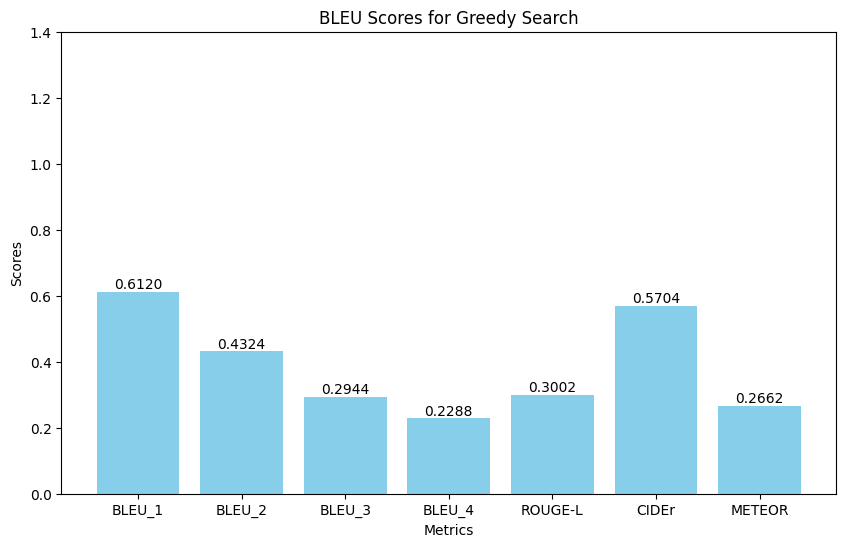

In [18]:
# Redirect standard output
original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
# Define the lambda function
predict_greedy= lambda image_tensor: predict_caption_greedy(image_tensor)
pycoco_scores, avg_meteor_score = evaluate_combined(testds, 2000, predict_greedy)
sys.stdout = original_stdout
print("Evaluation Scores for Greedy Search: \n")  
# Print the results
print("PyCOCOevalcap Scores: \n")
for key, value in pycoco_scores.items():
    print(f"{key}: {value:.4f}")
print(f"\nMETEOR Score: {avg_meteor_score:.4f}")

# Prepare data for plotting
metrics = list(pycoco_scores.keys())
scores = list(pycoco_scores.values())

# Add METEOR to the metrics and its average score
metrics.append("METEOR")
scores.append(avg_meteor_score)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('BLEU Scores for Greedy Search')
plt.ylim(0, 1.4)  # Assuming scores are between 0 and 1
for i in range(len(scores)):
    plt.text(i, scores[i], f'{scores[i]:.4f}', ha='center', va='bottom')

# Display the plot
plt.show()